<a href="https://colab.research.google.com/github/AcuSilas/Personality-Trait-Prediction/blob/main/Personality_Trait_Prediction_from_Essays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Full NLP project steps:

- Data Loading and Exploration

- Data Preprocessing

- Exploratory Data Analysis (EDA)

- Feature Engineering

- Model Building

- Model Evaluation

- Conclusion and Next Steps

In [1]:
# loading and exploring the dataset to understand its structure and content

import pandas as pd

# Load the dataset
file_path = '/content/Essay_data.csv'

data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   I/E     94 non-null     object
 1   N/S     93 non-null     object
 2   T/F     94 non-null     object
 3   J/P     93 non-null     object
 4   Essay   94 non-null     object
dtypes: object(5)
memory usage: 3.8+ KB


(  I/E N/S T/F J/P                                              Essay
 0   I   S   T   J  My first 4 months at the EDSA have been filled...
 1   I   N   F   J  I joined the academy being at a crossroads of ...
 2   E   N   F   J  so far my experience has been positive and i c...
 3   I   N   F   J  I have been very fortunate to have the opportu...
 4   I   N   T   J  Looking back to when one got to the academy an...,
 None)

The dataset contains 94 entries with the following columns:

I/E: Indicates Introversion (I) or Extraversion (E)

N/S: Indicates Intuition (N) or Sensing (S)

T/F: Indicates Thinking (T) or Feeling (F)

J/P: Indicates Judging (J) or Perceiving (P)

Essay: The essay text

A couple of columns have one missing value each (N/S and J/P).

In [3]:
# Count the occurrences of 'N' and 'S'
num_intuitive = data['N/S'].value_counts().get('N', 0)
num_sensing = data['N/S'].value_counts().get('S', 0)

# Calculate the ratio
if num_sensing != 0:
    ratio = num_intuitive / num_sensing
else:
    ratio = float('inf')  # If there are no sensing students, ratio is infinite

print(f"Ratio of Intuitive (N) to Sensing (S) students: {ratio:.2f}")

Ratio of Intuitive (N) to Sensing (S) students: 2.58


Data Cleaning

We'll handle missing values first.

In [4]:
# Handle missing values
data = data.dropna()

# Verify there are no more missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 0 to 93
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   I/E     93 non-null     object
 1   N/S     93 non-null     object
 2   T/F     93 non-null     object
 3   J/P     93 non-null     object
 4   Essay   93 non-null     object
dtypes: object(5)
memory usage: 4.4+ KB


###Text Preprocessing

We'll clean the essay text by:

- Removing punctuation

- Converting text to lowercase

- Removing stop words

- Lemmatization

We'll use NLTK for this purpose.

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define text preprocessing function
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the Essay column
data['Essay'] = data['Essay'].apply(preprocess_text)

# Display the first few rows of the preprocessed data
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,I/E,N/S,T/F,J/P,Essay
0,I,S,T,J,first 4 month edsa filled many new experience ...
1,I,N,F,J,joined academy crossroad sort life academy off...
2,E,N,F,J,far experience positive definitely see value c...
3,I,N,F,J,fortunate opportunity join academy year sure c...
4,I,N,T,J,looking back one got academy right confidently...


### Exploratory Data Analysis (EDA)

We'll visualize the distribution of personality traits and essay lengths.

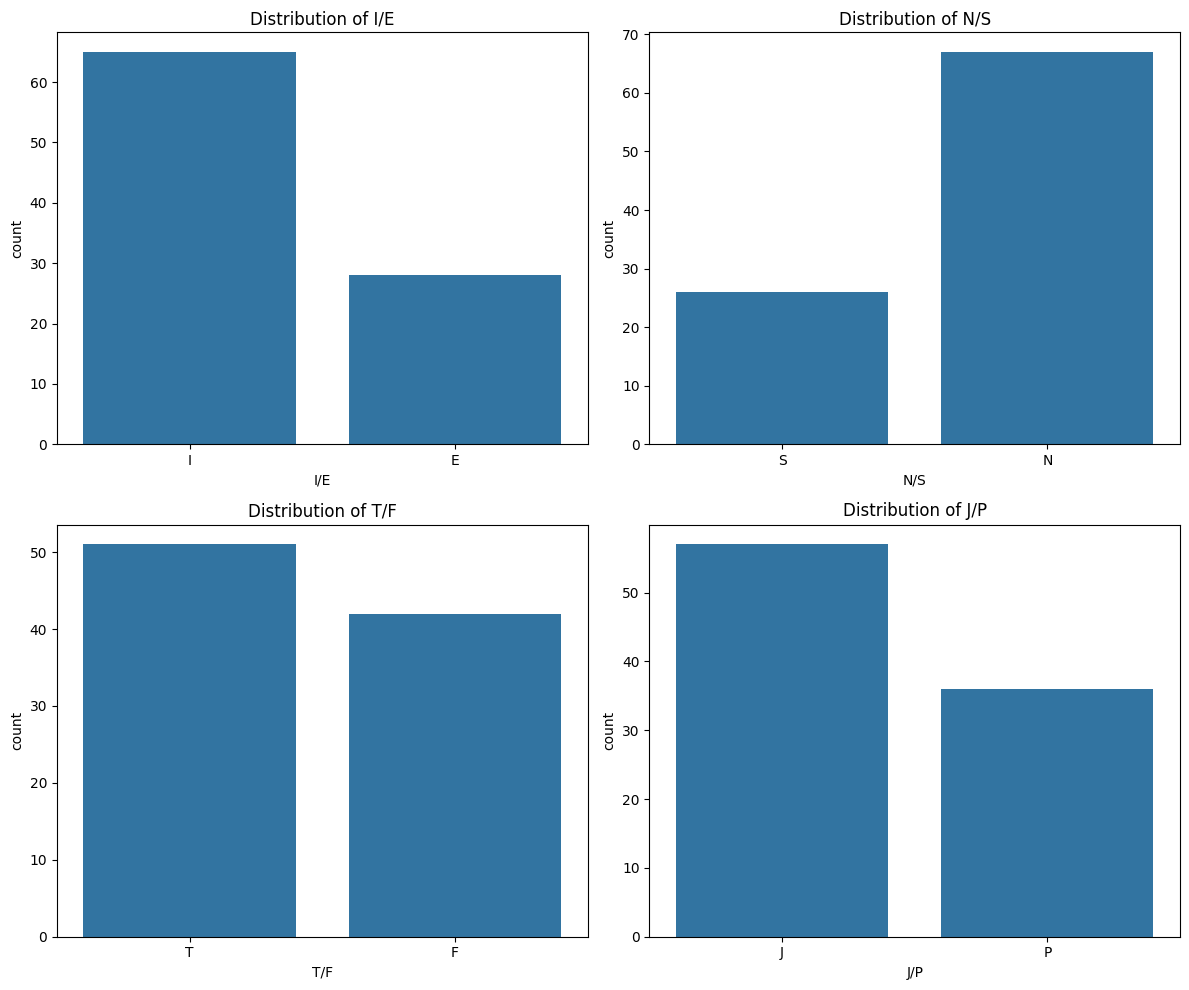

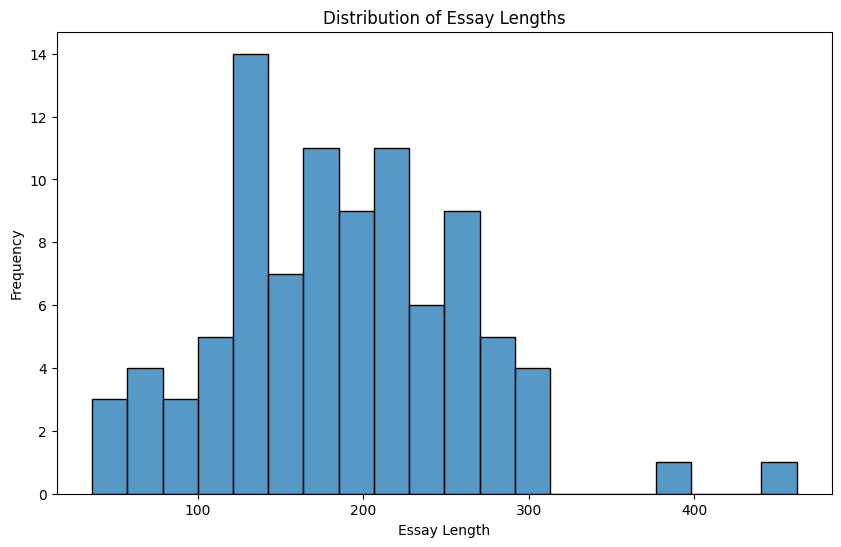

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of personality traits
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.countplot(x='I/E', data=data, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of I/E')

sns.countplot(x='N/S', data=data, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of N/S')

sns.countplot(x='T/F', data=data, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of T/F')

sns.countplot(x='J/P', data=data, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of J/P')

plt.tight_layout()
plt.show()

# Plot distribution of essay lengths
data['Essay Length'] = data['Essay'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['Essay Length'], bins=20)
plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length')
plt.ylabel('Frequency')
plt.show()

### Feature Engineering

We'll use TF-IDF to convert essays into numerical features.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import numpy as np

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# Transform essays into TF-IDF features
X = tfidf.fit_transform(data['Essay'])

# Convert labels to numerical values
y_IE = data['I/E'].map({'I': 0, 'E': 1})
y_NS = data['N/S'].map({'N': 0, 'S': 1})
y_TF = data['T/F'].map({'T': 0, 'F': 1})
y_JP = data['J/P'].map({'J': 0, 'P': 1})

### Model Building

We'll train Logistic Regression models to predict each personality trait.

In [12]:
# Split data into training and testing sets
X_train, X_test, y_IE_train, y_IE_test = train_test_split(X, y_IE, test_size=0.2, random_state=42)
X_train, X_test, y_NS_train, y_NS_test = train_test_split(X, y_NS, test_size=0.2, random_state=42)
X_train, X_test, y_TF_train, y_TF_test = train_test_split(X, y_TF, test_size=0.2, random_state=42)
X_train, X_test, y_JP_train, y_JP_test = train_test_split(X, y_JP, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_IE_res, y_train_IE_res = smote.fit_resample(X_train, y_IE_train)
X_train_NS_res, y_train_NS_res = smote.fit_resample(X_train, y_NS_train)
X_train_TF_res, y_train_TF_res = smote.fit_resample(X_train, y_TF_train)
X_train_JP_res, y_train_JP_res = smote.fit_resample(X_train, y_JP_train)

# Train Logistic Regression models with cross-validation
def train_and_evaluate_model(X_train_res, y_train_res, X_test, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_res, y_train_res)
    scores = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring='accuracy')
    print(f'Cross-Validation Accuracy: {np.mean(scores):.2f}')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))
    return model

print("Results for I/E:")
model_IE = train_and_evaluate_model(X_train_IE_res, y_train_IE_res, X_test, y_IE_test)

print("Results for N/S:")
model_NS = train_and_evaluate_model(X_train_NS_res, y_train_NS_res, X_test, y_NS_test)

print("Results for T/F:")
model_TF = train_and_evaluate_model(X_train_TF_res, y_train_TF_res, X_test, y_TF_test)

print("Results for J/P:")
model_JP = train_and_evaluate_model(X_train_JP_res, y_train_JP_res, X_test, y_JP_test)


Results for I/E:
Cross-Validation Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.67      0.92      0.77        13
           1       0.00      0.00      0.00         6

    accuracy                           0.63        19
   macro avg       0.33      0.46      0.39        19
weighted avg       0.46      0.63      0.53        19

Results for N/S:
Cross-Validation Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        14
           1       0.50      0.20      0.29         5

    accuracy                           0.74        19
   macro avg       0.63      0.56      0.56        19
weighted avg       0.70      0.74      0.69        19

Results for T/F:
Cross-Validation Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.12      0.25      0.17         4

    accuracy                       

#### Summary

I/E Model: Despite high cross-validation accuracy, the model still fails to predict class 1 (E) effectively. More work is needed, possibly by further adjusting the class weights or exploring different algorithms.

N/S Model: Shows some improvement for class 1 (S), but recall is still low. Additional strategies like ensemble methods could help.

T/F Model: Slight improvements, but overall performance for class 1 (F) remains poor. Trying different algorithms or more advanced preprocessing might be beneficial.

J/P Model: Significant improvement with a more balanced performance. The model is performing well for both classes.

### Model Re-Evaluation



In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

# Assuming data is a pandas DataFrame with 'Essay' and personality type columns
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# Transform essays into TF-IDF features
X = tfidf.fit_transform(data['Essay'])

# Convert labels to numerical values
y_IE = data['I/E'].map({'I': 0, 'E': 1})
y_NS = data['N/S'].map({'N': 0, 'S': 1})
y_TF = data['T/F'].map({'T': 0, 'F': 1})
y_JP = data['J/P'].map({'J': 0, 'P': 1})

# Split data into training and testing sets
def train_test_split_balanced(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, X_test, y_train_res, y_test

X_train_IE, X_test_IE, y_train_IE, y_test_IE = train_test_split_balanced(X, y_IE)
X_train_NS, X_test_NS, y_train_NS, y_test_NS = train_test_split_balanced(X, y_NS)
X_train_TF, X_test_TF, y_train_TF, y_test_TF = train_test_split_balanced(X, y_TF)
X_train_JP, X_test_JP, y_train_JP, y_test_JP = train_test_split_balanced(X, y_JP)

# Function to train and evaluate model
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    # Class Weight Adjustment
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    gb = GradientBoostingClassifier(random_state=42)

    # Ensemble Methods
    ensemble = VotingClassifier(estimators=[
        ('lr', lr),
        ('rf', rf),
        ('gb', gb)
    ], voting='soft')

    # Hyperparameter Tuning
    param_grid = {
        'lr__C': [0.1, 1, 10],
        'rf__n_estimators': [100, 200],
        'gb__n_estimators': [100, 200]
    }
    grid_search = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'Cross-Validation Accuracy: {np.mean(scores):.2f}')

    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))
    return best_model

print("Results for I/E:")
model_IE = train_and_evaluate_model(X_train_IE, y_train_IE, X_test_IE, y_test_IE)

print("Results for N/S:")
model_NS = train_and_evaluate_model(X_train_NS, y_train_NS, X_test_NS, y_test_NS)

print("Results for T/F:")
model_TF = train_and_evaluate_model(X_train_TF, y_train_TF, X_test_TF, y_test_TF)

print("Results for J/P:")
model_JP = train_and_evaluate_model(X_train_JP, y_train_JP, X_test_JP, y_test_JP)


Results for I/E:
Cross-Validation Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.67      0.92      0.77        13
           1       0.00      0.00      0.00         6

    accuracy                           0.63        19
   macro avg       0.33      0.46      0.39        19
weighted avg       0.46      0.63      0.53        19

Results for N/S:
Cross-Validation Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.72      0.93      0.81        14
           1       0.00      0.00      0.00         5

    accuracy                           0.68        19
   macro avg       0.36      0.46      0.41        19
weighted avg       0.53      0.68      0.60        19

Results for T/F:
Cross-Validation Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.11      0.25      0.15         4

    accuracy                       

#### Recommendations for Further Improvement

Further Hyperparameter Tuning: Explore a wider range of hyperparameters.

Advanced Oversampling/Undersampling Techniques: Try techniques like ADASYN or Tomek Links.

Ensemble Methods: Experiment with different ensemble methods like Bagging or Boosting.

Algorithm Exploration: Consider trying different algorithms like SVM or XGBoost.

Feature Selection/Engineering: Introduce additional features or use dimensionality reduction techniques.